# Equity Analyst Agent with Assistants API and Function calling

### This notebook showcases the capabilities of Azure OpenAI's Assistants API for an Equity Analyst Agent. 

Install the necessary Python packages (openai, matplotlib, tenacity, python-dotenv) for the notebook to function.

In [ ]:
%pip install openai matplotlib tenacity python-dotenv

Imports the necessary Python modules and classes used in the notebook. Note the openai module is used to interact with the Assistants API.

In [2]:
import os
from pathlib import Path
from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types.beta import Thread
from openai.types.beta.threads import Run

from tenacity import RetryError
import yfinance as yf
import requests
from azure_ai_util import AzureAIUtils, NotCompletedException

### Initialize Azure OpenAI Client
This cell crucial for establishing communication with Azure OpenAI services. 

- **Requirement**: Ensure that a `.env` file exists in the same directory as this notebook. This file should contain the necessary API credentials and configuration details, which you can obtain from https://ai.azure.com 

In [3]:
load_dotenv(".env")
client = AzureOpenAI(api_key=os.getenv("OPENAI_API_KEY"), 
                     azure_endpoint=os.getenv("OPENAI_ENDPOINT"),
                     api_version="2024-02-15-preview")

utils = AzureAIUtils(client)

### Create the assistant with tools and files


The `create_assistant` function creates an assistant with tools and files. The function takes the following parameters:
- `name`: The name of the assistant.
- `instructions`: The system message (or meta prompt) that gives the assistant a persona and context.
- `tools`: A list of tools that the assistant can use to perform tasks. Currently, these are `code_intrepreter` and `retriever`.
- `functions`: Custom functions that the assistant can use to perform tasks. Similar to function calling feature.
- `model`: The name of the model to use for the assistant.

In [4]:
DATA_COLLECTION_LOGIC_APPS_URI = os.getenv("DATA_COLLECTION_LOGIC_APPS_URI")

def get_proprietary_data(ticker: str, data_type: str, email: str) -> None:
    json_payload = {"ticker": ticker, "data_type": data_type, "email": email}
    headers = {"Content-Type": "application/json"}
    response = requests.post(DATA_COLLECTION_LOGIC_APPS_URI, json=json_payload, headers=headers)
    if response.status_code == 202:
        print("Email sent to: " + json_payload["to"])

def get_current_share_price(ticker: str) -> float:
    stock = yf.Ticker(ticker)
    return stock.history(period="1d")["Close"].iloc[-1]

In [5]:
# Fetch the files under the datasets directory
DATASETS = "datasets/"

assistant_files = [utils.upload_file(Path(DATASETS) / file) for file in os.listdir(DATASETS)]
file_ids = [file.id for file in assistant_files]

Create the assistant with tools and files

In [6]:
tools_list = [
    {"type": "code_interpreter"},
    {
        "type": "function",
        "function": {
            "name": "get_proprietary_data",
            "description": "Gets proprietary data from a Logic Apps workflow and notifies the user via email.",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker": {"type": "string", "description": "The stock ticker symbol."},
                    "data_type": {"type": "string", "description": "The type of data to retrieve. ARPU, EPS, Margin, etc."},
                    "email": {"type": "string", "description": "The email address to notify."}
                },
                "required": ["to", "content"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "get_current_share_price",
            "description": "Get the current share price of a stock or symbol.",
            "parameters": {
                "type": "object",
                "properties": {"ticker": {"type": "string", "description": "The ticker of the stock"}},
                "required": ["ticker"],
            },
        },
    }
]

In [7]:
def call_functions(client: AzureOpenAI, thread: Thread, run: Run) -> None:
    print("Function Calling")
    required_actions = run.required_action.submit_tool_outputs.model_dump()
    print(required_actions)
    tool_outputs = []
    import json

    for action in required_actions["tool_calls"]:
        func_name = action["function"]["name"]
        arguments = json.loads(action["function"]["arguments"])

        if func_name == "get_current_share_price":
            output = get_current_share_price(ticker=arguments["ticker"])
            tool_outputs.append({"tool_call_id": action["id"], "output": output})
        elif func_name == "get_proprietary_data":
            print("Fetching proprietary data")
            ticker = arguments["ticker"]
            data_type = arguments["data_type"]
            email = arguments["email"]
            get_proprietary_data(ticker, data_type, email)

            tool_outputs.append({"tool_call_id": action["id"], "output": "Fetched proprietary data and notified user."})
        else:
            raise ValueError(f"Unknown function: {func_name}")

    print("Sending tool outputs to the thread.")
    client.beta.threads.runs.submit_tool_outputs(thread_id=thread.id, run_id=run.id, tool_outputs=tool_outputs)

In [8]:
assistant = client.beta.assistants.create(
    name="Equity Analyst",
    instructions=("You are an equity analyst that performs analysis on the given datasets. "
                  "Use the given tools to help you gather data and perform analysis."
                  "With your tools, you can retrieve the latest stock price, fetch proprietary data, and notify user."),
    tools=tools_list,
    file_ids=file_ids,
    model=os.getenv("OPENAI_MODEL_NAME")
)

Create a thread, which represents a conversation. It is recommended to create one thread per user. 

In [9]:
thread = client.beta.threads.create()

In [10]:
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type

@retry(
    stop=stop_after_attempt(15),
    wait=wait_exponential(multiplier=1.5, min=4, max=20),
    retry=retry_if_exception_type(NotCompletedException),
)
def get_run_lifecycle_status(thread_id, run_id):
    run = client.beta.threads.runs.retrieve(thread_id=thread_id, run_id=run_id)
    print(f"Run status: {run.status}")
    if run.status in ["completed", "failed", "expired", "cancelled"]:
        print(f"Run info: {run}")
        return run
    elif run.status == "requires_action":
        print(f"Run requires action: {run}")
        call_functions(client, thread, run)
    else:
        raise NotCompletedException("Run not completed yet")

Create a thread run

In [11]:
def analyst_assistant(content: str):
    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=content)

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions=f"You are a equity analyst who maps out the ask of the user to an equity analyst's task and thinks step by step to analyze, including making use of the tools. Make generic assumptions",
    )

    try:
        run = get_run_lifecycle_status(thread.id, run.id)
        messages = client.beta.threads.messages.list(thread_id=thread.id)
        utils.format_response(messages)
    except RetryError:
        print("Operation failed or timed out after maximum retries.")
    except NotCompletedException:
        print("Operation did not complete in the expected status.")


### Have the assistant perform a DCF valuation

In [12]:
analyst_assistant("Get MSFT and JPM share price along with ARPU for 10/1/2023 to 12/31/2023 and notify gok@microsoft.com.")

Run status: queued
Run status: in_progress
Run status: in_progress
Run status: requires_action
Run requires action: Run(id='run_K7HtoigzhL1Wb5zSHNj1vJpS', assistant_id='asst_YpPVkonzeK57yQBAtbl1imTq', cancelled_at=None, completed_at=None, created_at=1707891324, expires_at=1707891924, failed_at=None, file_ids=['assistant-e7e5faARedy5axcnTArDAIiN'], instructions="You are a equity analyst who maps out the ask of the user to an equity analyst's task and thinks step by step to analyze, including making use of the tools. Make generic assumptions", last_error=None, metadata={}, model='gpt-4', object='thread.run', required_action=RequiredAction(submit_tool_outputs=RequiredActionSubmitToolOutputs(tool_calls=[RequiredActionFunctionToolCall(id='call_QnF4nLCsRiR9jl3ommsRByCB', function=Function(arguments='{"ticker": "MSFT"}', name='get_current_share_price'), type='function'), RequiredActionFunctionToolCall(id='call_q16A4JBrG0UEwLgdfZxceNhb', function=Function(arguments='{"ticker": "JPM"}', name='g

c:\Users\gok\AppData\Local\anaconda3\envs\aoai\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\gok\AppData\Local\anaconda3\envs\aoai\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


Fetching proprietary data
Fetching proprietary data
Sending tool outputs to the thread.
user:
Get MSFT and JPM share price along with ARPU for 10/1/2023 to 12/31/2023 and notify gok@microsoft.com.



In [13]:
analyst_assistant("Perform a discounted cash flow valuation using the provided dataset, and print the code along with its executed output that was used for this calculation.")

Run status: queued
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: completed
Run info: Run(id='run_47jUAJTC43zpx2IC4UqLtwEv', assistant_id='asst_YpPVkonzeK57yQBAtbl1imTq', cancelled_at=None, completed_at=1707891461, created_at=1707891387, expires_at=None, failed_at=None, file_ids=['assistant-e7e5faARedy5axcnTArDAIiN'], instructions="You are a equity analyst who maps out the ask of the user to an equity analyst's task and thinks step by step to analyze, including making use of the tools. Make generic assumptions", last_error=None, metadata={}, model='gpt-4', object='thread.run', required_action=None, started_at=1707891388, status='completed', thread_id='thread_9WtW59kO78BZzrbEM7v3WHIr', tools=[ToolAssistantToolsCode(type='code_interpreter'), ToolAssistantToolsFunction(function=FunctionDefinition(name='get_proprietary_data', description='Gets proprietary data from a Logic Apps work

Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: completed
Run info: Run(id='run_xSEXFLhX1qOrAigcLIJt6gGI', assistant_id='asst_YpPVkonzeK57yQBAtbl1imTq', cancelled_at=None, completed_at=1707891540, created_at=1707891485, expires_at=None, failed_at=None, file_ids=['assistant-e7e5faARedy5axcnTArDAIiN'], instructions="You are a equity analyst who maps out the ask of the user to an equity analyst's task and thinks step by step to analyze, including making use of the tools. Make generic assumptions", last_error=None, metadata={}, model='gpt-4', object='thread.run', required_action=None, started_at=1707891486, status='completed', thread_id='thread_9WtW59kO78BZzrbEM7v3WHIr', tools=[ToolAssistantToolsCode(type='code_interpreter'), ToolAssistantToolsFunction(function=FunctionDefinition(name='get_proprietary_data', description='Gets proprietary data from a Logic Apps workflow and notifies t

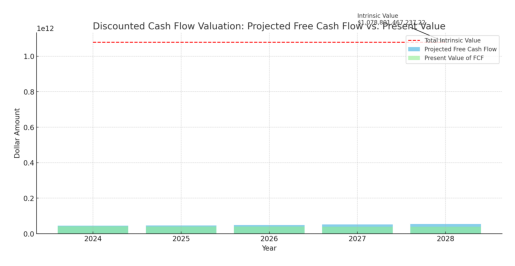

assistant:
The bar chart above visually represents the discounted cash flow (DCF) valuation. Here's how to interpret the chart:

- The sky-blue bars show the projected free cash flow (FCF) for each year from 2024 to 2028. These are the amounts of cash the company is expected to generate after covering all expenses and investments.
- The light green bars represent the present value of those projected FCFs. This value is less than the projected FCF because future cash is discounted to its current worth.
- The red dashed line represents the total intrinsic value of the company calculated from the DCF analysis, which is approximately $1.08 trillion.

The intrinsic value is the sum of all the light green bars plus the value of all future cash flows beyond 2028 (represented by the terminal value, not shown separately in the chart).

For someone new to finance and investing, this chart helps visualize that a company's value is not just the cash it has today, but the cash it can generate in th

In [14]:
analyst_assistant("Summarize and Visualize this information to someone new to finance and investing.")

### Delete the thread and assistant

In [ ]:
for entity in [(client.beta.assistants, assistant), (client.beta.threads, thread)]:
    entity[0].delete(entity[1].id)

for file in assistant_files:
    client.files.delete(file.id)